In [2]:
#prob duplicates, this can be cleaned up for sure 
#c /p from all my NBS
import matplotlib.pyplot as plt
import numpy as np
import pytest
from tests.test_plotting import tol_1d
import os
from desc.plotting import *
from desc.examples import get
from desc import set_device
from desc.optimize import Optimizer
from desc.io import load
from desc.plotting import plot_boozer_surface
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_boozer_surface
%matplotlib inline
from desc.plotting import plot_comparison

from desc.continuation import solve_continuation_automatic
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.grid import LinearGrid, ConcentricGrid
from desc.objectives import (
    AspectRatio,
    FixBoundaryR,
    FixBoundaryZ,
    FixIota,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
    QuasisymmetryTwoTerm,
    GammaC,
    Elongation,
    GenericObjective
)

DESC version 0.11.1+1298.gc489a9b3f.dirty,using JAX backend, jax version=0.4.30, jaxlib version=0.4.30, dtype=float64
Using device: CPU, with 701.86 GB available memory


Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

First, the calculation of Gamma_C [tweaks to Kaya's test function]

In [3]:
@pytest.mark.unit
@pytest.mark.mpl_image_compare(remove_text=True, tolerance=tol_1d)
def test_Gamma_c(eq):
    '''
    Inputs - eq: an equilibrium 
    
    Ouputs - rho (array-like): radial points gamma_c is evaluated for 
            gamma_c (array-like) for the desired amount of radial evaluations
            **** when it prints gamma_c, it only outputs the rho= 0 value, needs fixing, but it saves the array correctly. Just a printing issue 
        
    '''
    
    # Define the radial coordinate rho
    rho = np.linspace(0, 1, 10)
    
    # Create a grid in (rho, theta, zeta) coordinates
    grid = eq.get_rtz_grid(
        rho,
        np.array([0]),
        np.linspace(0, 20 * np.pi, 1000),
        coordinates="raz",
        period=(np.inf, 2 * np.pi, np.inf),
    )
    
    # Compute Gamma_c on the grid
    data = eq.compute("Gamma_c", grid=grid)
    
    # Ensure that Gamma_c is finite
    assert np.isfinite(data["Gamma_c"]).all()
    
    # Save the values of rho and Gamma_c to variables
    gamma_c = data["Gamma_c"]
    
    
    # Plot Gamma_c vs. radial coordinate
    fig, ax = plt.subplots()
    ax.plot(rho, grid.compress(gamma_c))
    ax.set_xlabel('Radial Coordinate (rho)')
    ax.set_ylabel('Γ_c')
    ax.set_title('Γ_c vs. Radial Coordinate')
    ax.grid(True)
    
    return fig, rho, gamma_c

In [ ]:
#Running Gamma_c calculations
eq = Equilibrium.load("path_to_eq_file")
#uncomment following two lines if necessary 
#eq.pressure._params_derivative = None
#eq.iota._params_derivative = None
fig, rho, gamma_c = test_Gamma_c(eq)

The Optimization section:

In [4]:
eq0 = Equilibrium.load("input_equilibrium")
eq0.pressure._params_derivative = None
eq0.iota._params_derivative = None
    

def run_opt_step(k, eq):
    """Run a step of the optimization example."""
    # this step will only optimize boundary modes with |m|,|n| <= k
    # we create an ObjectiveFunction, in this case made up of multiple objectives
    # which will be combined in a least squares sense
    
    shape_grid = LinearGrid(M = int(eq.M), N = int(eq.N), rho=np.array([1.0]), NFP=eq.NFP, sym=True, axis=False)
    
    ntransits = 13
    
    zeta_field_line = np.linspace(0, 2*np.pi * ntransits, 64*ntransits)
    alpha = 0
    rho = np.linspace(0.85,1.0,2)
    #rho = np.linspace(0.85, 1.0, 2)
    flux_surface_grid = LinearGrid(rho=rho, M=eq.M_grid, N=eq.N_grid, sym=eq.sym, NFP=eq.NFP)

    
    objective = ObjectiveFunction(
        (
            GammaC(eq=eq, grid=flux_surface_grid, alpha=alpha, zeta=zeta_field_line, deriv_mode="fwd", batch=False, weight=1e3),
            
          
            Elongation(eq=eq, grid=shape_grid, bounds=(0.5, 2.0), weight=1e3),
            GenericObjective(f="curvature_k2_rho", thing=eq,grid=shape_grid, bounds=(-75, 15), weight=2e3),
           
        ),
    )
    # as opposed to SIMSOPT and STELLOPT where variables are assumed fixed, in DESC
    # we assume variables are free. Here we decide which ones to fix, starting with
    # the major radius (R mode = [0,0,0]) and all modes with m,n > k
    R_modes = np.vstack(
        (
            [0, 0, 0],
            eq.surface.R_basis.modes[
                np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :
            ],
        )
    )
    Z_modes = eq.surface.Z_basis.modes[
        np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :
    ]
    # next we create the constraints, using the mode number arrays just created
    # if we didn't pass those in, it would fix all the modes (like for the profiles)
    constraints = (
        ForceBalance(eq, grid = ConcentricGrid(L=round(2*eq.L), M=round(1.5*eq.M), N=round(1.5*eq.N), NFP=eq.NFP,sym=eq.sym)),
        FixBoundaryR(eq=eq, modes=R_modes),
        FixBoundaryZ(eq=eq, modes=Z_modes),
        FixPressure(eq=eq),
        FixIota(eq=eq),
        FixPsi(eq=eq),
    )
    # this is the default optimizer, which re-solves the equilibrium at each step
    optimizer = Optimizer("proximal-lsq-exact")

    eq_new, history = eq.optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=30,  # we don't need to solve to optimality at each multigrid step
        verbose=3,
        copy=True,  # don't modify original, return a new optimized copy
        options={
            # Sometimes the default initial trust radius is too big, allowing the
            # optimizer to take too large a step in a bad direction. If this happens,
            # we can manually specify a smaller starting radius. Each optimizer has a
            # number of different options that can be used to tune the performance.
            # See the documentation for more info.
            "initial_trust_ratio": 1.0,
        },
    )

    return eq_new
    jax.clear_caches()
    
eq = eq0
for k in np.arange(1,eq.M+1,1):
    eq = run_opt_step(k, eq)
    eq.save(f"opt_step_{k}.h5")

RuntimeError: [31mcould not infer file format from file name, it should be provided as file_format[0m

In [7]:
# Function to reshape and average the gamma_c array - used in plotting 
def reshape_and_average(arr, target_length, factor):
    reshaped = arr.reshape((target_length, factor))
    averaged = reshaped.mean(axis=1)
    return averaged

After running Optimization, plug in before and after eqs. This functions runs all of the tests I found to be helpful in analysis 

In [8]:
def optimization_analysis(eqbefore, eqafter):
    '''
    This function runs all of the tests for optimization
    
    inputs -eqbefore: equilibrium before optimization 
            eqafter: equilibrium after optimization 
    
    '''
    
    # First, 3D plots - commented for memory issues 
    #print("Equilibrium before optimization")
    #fig = plot_3d(eqbefore, "R")
    #fig.show()
    
    #print("Equilibrium after optimization")
    #fig = plot_3d(eqafter, "R")
    #fig.show()
    
    # Next, 2D comparison plot
    print("Comparison of equilibrium before and after optimization")
    fig, ax = plot_comparison(
        eqs=[eqbefore, eqafter],
        labels=[
            "Before optimization",
            "After optimization for $\Gamma_c$",
        ]
    )
    plt.show()
    
    # Next, compute Gamma_C for each 
    # Before
    fig, rho_before, gamma_c_before = test_Gamma_c(eqbefore)  
    plt.show()
        
    # After    
    fig, rho_after, gamma_c_after = test_Gamma_c(eqafter)
    plt.show()
    
    # Create plot of each
    series = {
        "Before optimization": {
            "$rho$": rho_before,
            "$\Gamma_c$": gamma_c_before,
            "color": 'red',
            "linestyle": 'solid'
        },
        "After optimization": {
            "$rho$": rho_after,
            "$\Gamma_c$": gamma_c_after,
            "color": 'blue',
            "linestyle": 'solid'
        }
    }

    # Plotting
    plt.figure(figsize=(10, 6))

    for name, data in series.items():
        rho = data["$rho$"]
        gamma_c = data["$\Gamma_c$"]
        color = data["color"]
        linestyle = data["linestyle"]
    
        if len(rho) * 1000 == len(gamma_c):  # Ensure we have the correct reshaping dimensions
            gamma_c = reshape_and_average(gamma_c, len(rho), 1000)
    
        plt.plot(rho, gamma_c, label=name, linewidth=1.5, color=color, linestyle=linestyle)

    plt.xlabel("Radial Coordinate", fontsize=20)
    plt.ylabel("$\Gamma_c$", fontsize=20)
    plt.xlim(0.2, 1)  # Set x-axis range
    plt.title("Radial Coordinate vs $\Gamma_c$ Before and After Optimization", fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    
    #comparing QS error

    # Add QS error before optimization
    fig, ax, data_before = plot_qs_error(eqbefore, fB=True, fC=False, fT=False, helicity=(0, eqbefore.NFP), rho=np.linspace(0, 1, 25), return_data=True)
    print(data_before)

    # Add QS error after optimization
    fig, ax, data_after = plot_qs_error(eqafter, fB=True, fC=False, fT=False, helicity=(0, eqafter.NFP), rho=np.linspace(0, 1, 25), return_data=True)
    print(data_after)

    # Extract data and remove the first values
    rho_before = data_before['rho'][1:]
    f_B_before = data_before['f_B'][1:]
    rho_after = data_after['rho'][1:]
    f_B_after = data_after['f_B'][1:]

    # Plotting
    plt.figure(figsize=(10, 6))

    plt.plot(rho_before, f_B_before, label="Before optimization", linewidth=1.5, color='red', linestyle='solid', marker = "o")
    plt.plot(rho_after, f_B_after, label="After optimization", linewidth=1.5, color='blue', linestyle='solid', marker = "o")

    plt.xlabel("Radial Coordinate", fontsize=20)
    plt.ylabel("f_B", fontsize=20)
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title("QS Error (f_B) Before and After Optimization", fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

Comparison of equilibrium before and after optimization


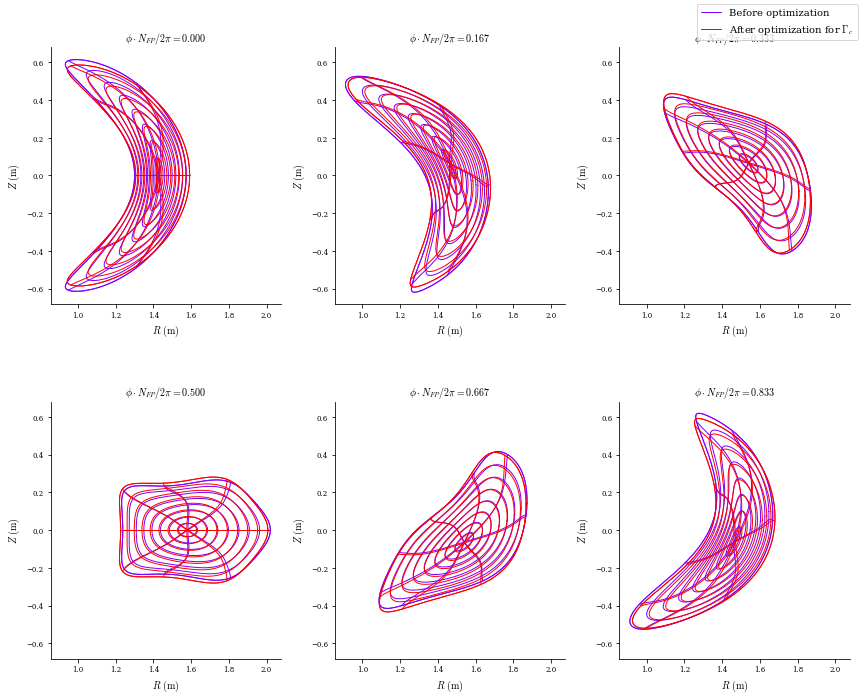

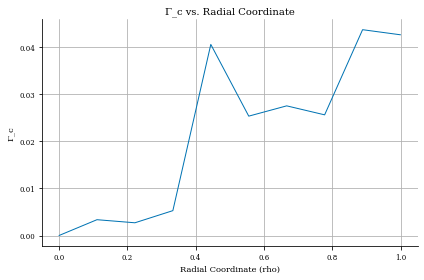

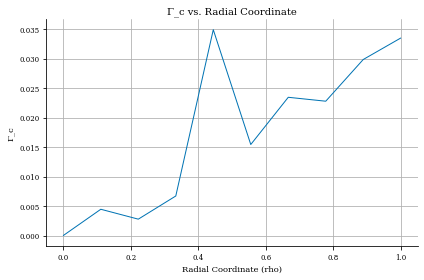

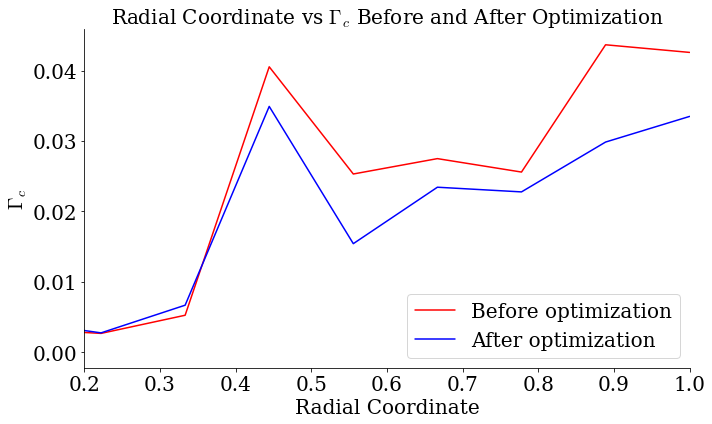

{'f_B': array([2.82592146e-15, 8.86148360e-03, 1.77449035e-02, 2.66716302e-02,
       3.56606008e-02, 4.47271832e-02, 5.38818006e-02, 6.31287968e-02,
       7.24657558e-02, 8.18824137e-02, 9.13609151e-02, 1.00877221e-01,
       1.10403754e-01, 1.19913074e-01, 1.29381681e-01, 1.38792748e-01,
       1.48137275e-01, 1.57414344e-01, 1.66632532e-01, 1.75814723e-01,
       1.85005811e-01, 1.94276104e-01, 2.03702703e-01, 2.13296294e-01,
       2.22833790e-01]), 'f_C': array([], dtype=float64), 'f_T': array([], dtype=float64), 'rho': array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
       0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
       0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
       0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
       0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ])}
{'f_B': array([2.94435156e-15, 8.25373092e-03, 1.65252200e-02, 2.48314519e-02,
       3.31867093e-02, 4.16014056e-02, 5.00807952e-0

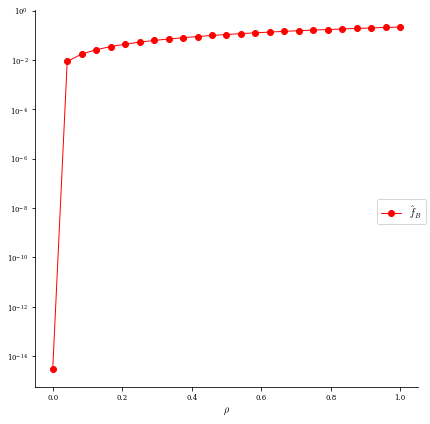

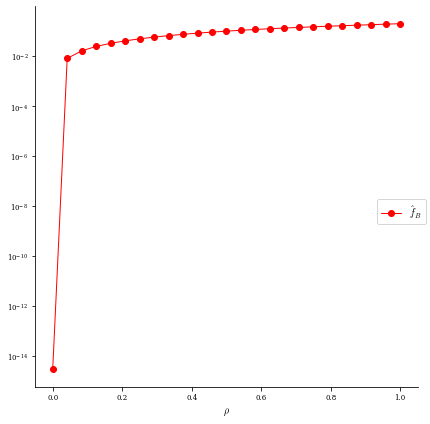

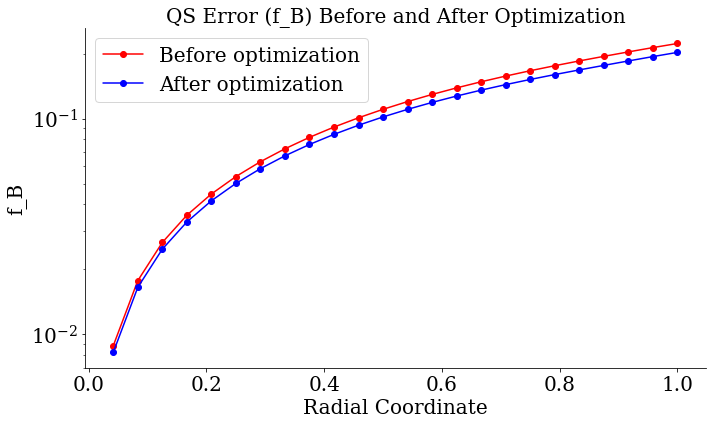

In [9]:
#Before file QA4 (i think)
eqbeforeQA4 = Equilibrium.load("/scratch/gpfs/gh7283/DESC/tests/neoclassical_test-equilibrium-0.208.h5")
eqbeforeQA4.pressure._params_derivative = None
eqbeforeQA4.iota._params_derivative = None

#after file QA4 (i think)
eqafterQA4 = Equilibrium.load("/scratch/gpfs/gh7283/DESC/docs/notebooks/QA4opt_step_3.h5")
eqafterQA4.pressure._params_derivative = None
eqafterQA4.iota._params_derivative = None

optimization_analysis(eqbeforeQA4, eqafterQA4)